## **Paths**

In [ ]:
image_folder = 'NLMCXR_png'
df_path = 'pickle_files/df_final.pkl'
chexnet_weights = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

folder_name = 'pickle_files'
tr_file_name = 'train.pkl'
te_file_name = 'test.pkl'

## **Imports**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='white')

import joblib 
import os

import cv2
import imgaug.augmenters as iaa

from nltk.translate.bleu_score import sentence_bleu 

import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM, Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add, AveragePooling2D, GRU, Conv2D, UpSampling2D, Multiply
from keras.layers.core import Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.compat.v1.enable_eager_execution()


## **Loading Data**

In [ ]:
train = pd.read_pickle(os.path.join(folder_name,tr_file_name))
test = pd.read_pickle(os.path.join(folder_name,te_file_name))
train.shape,test.shape

((4487, 8), (563, 8))

## **Tokenizer**

In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))



The max and min value of "caption length" was found to be 135 and 4 respectively
The 80 percentile value of caption_len which is 28 will be taken as the maximum padded value for each impression


# **Model**

## **Hyperparameters**

In [ ]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Data pipeline**

In [ ]:
class Dataset():
  # images converted to context vector and corresponding captions
    def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
        """
        df = dataframe containing image_1 and image_2 and the impression.
        """
        self.image1 = df.image_1
        self.image2 = df.image_2
        self.caption = df.impression_ip #input
        self.caption1 = df.impression_op  # output
        self.input_size = input_size 
        self.tokenizer = tokenizer
        self.augmentation = augmentation
        self.max_pad = max_pad

        #image augmentation
        
        self.aug1 = iaa.Fliplr(1) #flip images horizaontally
        self.aug2 = iaa.Flipud(1) #flip images vertically


    def __getitem__(self,i):
        """
        Gets the record at index 'i', resizes the images and applies augmentation
        """
        image1 = cv2.imread(self.image1[i], cv2.IMREAD_UNCHANGED)/255 
        image2 = cv2.imread(self.image2[i], cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
        image1 = cv2.resize(image1, self.input_size, interpolation = cv2.INTER_NEAREST)
        image2 = cv2.resize(image2, self.input_size, interpolation = cv2.INTER_NEAREST)
        
        # Print messages if missing images are found
        if image1.any()==None:
            print("%i , %s image sent null value"%(i,self.image1[i]))
        if image2.any()==None:
            print("%i , %s image sent null value"%(i,self.image2[i]))


        # Tokenizing and Padding the captions
        caption = self.tokenizer.texts_to_sequences(self.caption[i : i + 1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption = pad_sequences(caption, maxlen = self.max_pad, padding = 'post') #opshape:(input_length,)
        caption = tf.squeeze(caption, axis=0) #opshape = (input_length,) removing unwanted axis if present

        caption1 = self.tokenizer.texts_to_sequences(self.caption1[i : i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption1 = pad_sequences(caption1, maxlen = self.max_pad, padding = 'post') #opshape: (input_length,)
        caption1 = tf.squeeze(caption1, axis = 0) #opshape = (input_length,) removing unwanted axis if present



        # Applying the augmentation
        if self.augmentation:  
            a = np.random.uniform()
            
            if a<0.333:
                image1 = self.aug1.augment_image(image1)
                image2 = self.aug1.augment_image(image2)
                
            elif a<0.667:
                image1 = self.aug2.augment_image(image1)
                image2 = self.aug2.augment_image(image2)
                
            else: 
                #applying no augmentation
                pass;

    
        return image1,image2,caption,caption1

    
    def __len__(self):
        return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):    
    """
    Divide data into batches.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] 
        data = [self.dataset[j] for j in indexes] 
        
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad
        return tuple([[batch[0], batch[1], batch[2]], batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): 
        # returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): 
        # runs at the end of each epoch to shuffle data
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **CHEXNET**
[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Dense-121 layered model which is trained on thousands of chest x-ray images for the classification of 14 diseases. We can load the weights of that model and pass the image through it.

In [ ]:
def create_chexnet(chexnet_weights = chexnet_weights, input_size = input_size):
    
    model = tf.keras.applications.DenseNet121(include_top = False, input_shape = input_size + (3,)) #importing densenet the last layer will be a relu activation layer

    #we need to load the weights so setting the architecture of the model as same as the one of the chexnet
    x = model.output #output from chexnet
    x = GlobalAveragePooling2D()(x)
    x = Dense(14, activation = "sigmoid", name = "chexnet_output")(x) #here activation is sigmoid as seen in research paper

    chexnet = tf.keras.Model(inputs = model.input, outputs = x)
    chexnet.load_weights(chexnet_weights)
    chexnet = tf.keras.Model(inputs = model.input, outputs = chexnet.layers[-3].output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
    #since we are using attention here
    return chexnet

## Attention Model

In [ ]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

### Image Encoder Layer

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
    """
    Return image backbone features after passing it through chexnet.
    """
    def __init__(self, name = "image_encoder_block"):
        super().__init__()
        self.chexnet = create_chexnet()
        self.chexnet.trainable = False

    def call(self,data):
        op = self.chexnet(data) #op shape: (None,7,7,1024)
        return op 

## Global Flow and Context Flow

This architecture implementation is taken from [Attention guided chained context aggregation for image segmentation](https://https://arxiv.org/pdf/2002.12041.pdf) which was used for image segmentation but we will use it to extract image information. The outputs from Image encoder (ie chexnet) will be sent to global flow. Then outputs from both the chexnet and global flow will be concatted and sent to context flow. Here global flow extracts the global information of image while context flow will get the local features of the images. This will be then sent to decoder after reshaping, and applying batch norm and dropout.

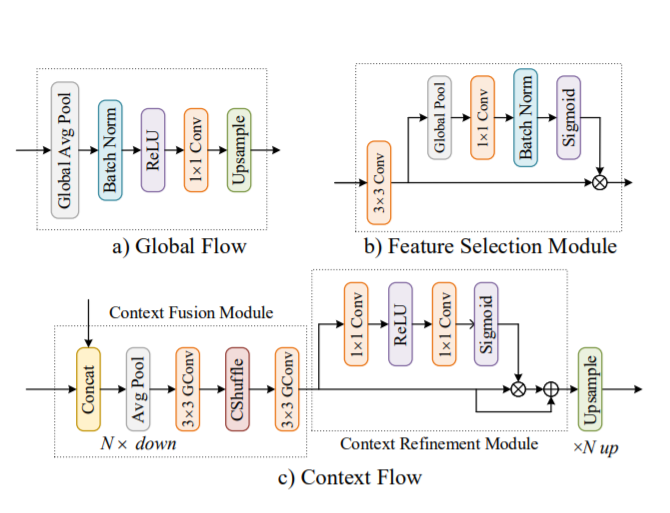

**Global Flow**


1.   Here Global flow will take the information from Image encoder layer and then I will apply global average pooling which will result in (#,1,1,no. of filters).
2.   Then we will apply bn, relu, 1*1 Convulution and upsample then to the same shape as the input.








In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, X , name = "global_flow"): #X = shape of the input
        super().__init__(name=name)
        self.matrix_shape = X[1:] #X.shape[1:]
        self.avgpooling = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.activation = Activation('relu')
        self.conv = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides = 1,
                    padding = "same",
                    activation = 'relu'
                    )
        self.upsample = UpSampling2D(size = (self.matrix_shape[1], self.matrix_shape[1]),
                                     interpolation = 'bilinear')
        
    def call(self, X):
        # implement the global flow operatiom
        X = self.avgpooling(X) #shape: (batch size,1,no. of filters)
        X = tf.expand_dims(tf.expand_dims(X, 1), 1) #op shape = batch-size*1*1*number of filters
        X = self.bn(X)
        X = self.activation(X)
        X = self.conv(X) #op shape = None*1*1*number of filters
        
        #we need to get same shape as input to this layer
        X = self.upsample(X)
        
        return X

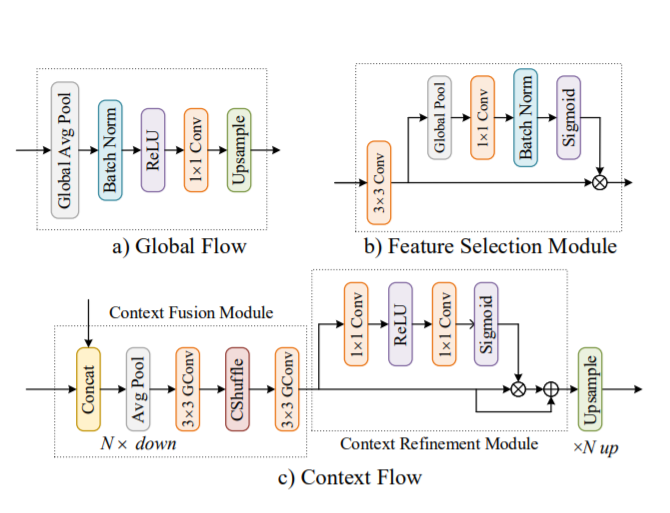

**Context Flow**


1.   We will get the data from both global flow and the image encoder layer and concat it on the last axis.
2.   This is then applied average pooling which reduces the size of feature map by N* times.
3.  Then a 3*3 single convulation will be applied twice. (No CShuffle will be applied)
4.  After that we will apply 1\*1 convulation, followed by relu activation, then again 1\*1 convulation followed by sigmoid activation. This is multipled with output from context fusion module and then added to output from the context refinement model which will then be upsampled with the same size as the input (here conv2d transpose will be used to get the same number of filters as of that of the input).



In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, X, name = "context_flow"): 
        super().__init__(name = name) # X is shape of INP, FLOW = X[0], X[1] 
        x, x1 = X[0], X[1]
        X = x[1], x[2], x[3] + x1[3]
        self.matrix_shape = X 
        self.global_shape = x1[1:]
        self.concat = Concatenate(axis = -1)
        self.avgpooling = AveragePooling2D(pool_size = 1,strides = self.matrix_shape[:2])
        self.bn = BatchNormalization()
        self.activation1 = Activation('relu')
        self.activation2 = Activation('relu')
        self.activation3 = Activation('sigmoid')
        
        self.conv1 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides = 1,
                    padding = "same",
                    activation = 'relu'
                    )
        
        self.conv2 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides = 1,
                    padding = "same",
                    activation = 'relu'
                    )
        
        self.conv3 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides = 1,
                    padding = "same",
                    activation = 'relu'
                    )
        self.conv4 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides = 1,
                    padding = "same",
                    activation = 'relu'
                    )
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = tf.keras.layers.Conv2DTranspose( 
                            # no. filters is equal to the no. of filters in output from global flow
                            filters = self.global_shape[-1],
                            kernel_size = self.global_shape[:2],
                            strides = 1,
                            padding = "valid", 
                            activation = 'relu',
                            use_bias = False
                            )
        
    def call(self, X): 
        INP, FLOW = X[0], X[1] 
        conc_op = self.concat([INP,FLOW])
        x = self.avgpooling(conc_op) #op_shape = batch_size*1*1*no. of filters
        x = self.conv1(x)
        x = self.conv2(x)
        y = self.conv3(x)
        y = self.activation1(y)
        y = self.conv4(y)
        y = self.activation3(y)
        mult = self.multiply([y,x])
        add = self.add([mult,x])
        X = self.upsample(add) #shape = batch_size*inp_w*inp_h*inp
        return X 

### Encoder

In [ ]:
def encoder(image1, image2, dense_dim = dense_dim, dropout_rate = dropout_rate):
    """
    Takes image1,image2
    gets the final encoded vector of these
    """
    #image1
    im_encoder = Image_encoder()

    bkfeat1 = im_encoder(image1) #shape: (None,49,1024)
    gf = global_flow(bkfeat1.shape)
    gf_op = gf(bkfeat1)
    cf = context_flow((bkfeat1.shape,gf_op.shape))
    cf_op = cf((bkfeat1,gf_op))
    bkfeat1 = Add()([gf_op, cf_op])

    #image2
    bkfeat2 = im_encoder(image2) #shape: (None,49,1024)
    gf_op2 = gf(bkfeat2)
    cf_op2 = cf((bkfeat2,gf_op2))
    bkfeat2 = Add()([gf_op2,cf_op2])  


    #combining image1 and image2

    concat = Concatenate(axis = -1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,98,1024)
    concat = Dense(dense_dim,name = 'encoder_dense_final',activation = 'relu')(concat)
    op = tf.reshape(concat,(-1,concat.shape[1]*concat.shape[2],concat.shape[3]))
    bn = BatchNormalization(name = "encoder_batch_norm")(op) #(dense)#
    dropout = Dropout(dropout_rate, name = "encoder_dropout")(bn)
    return dropout

Global Attention equations



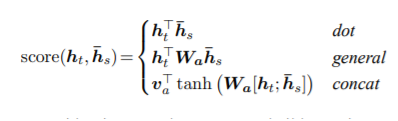

### Global Attention Layer

In [ ]:
# class global_attention(tf.keras.layers.Layer):
# """
# calculate global attention
# """
#   def __init__(self,dense_dim = dense_dim):
#     super().__init__()
#     # Intialize variables needed for Concat score function here
#     self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
#     self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
#     self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
#       #op (None,98,1)


#   def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
#     decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
#     tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
#     tanh_output =  tf.nn.tanh(tanh_input)
#     attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
#     op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
#     context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


#     return context_vector,attention_weights


In [ ]:
class global_attention(tf.keras.layers.Layer):
    """
    Calculates global attention
    """
    def __init__(self,dense_dim = dense_dim):
        super().__init__()
        # Intialize variables needed for Concat score function here
        self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
        self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
        self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
          #op (None,98,1)


    def call(self, encoder_output, decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
        decoder_h = tf.expand_dims(decoder_h, axis=1) #shape: (None,1,dense_dim)
        tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
        tanh_output =  tf.nn.tanh(tanh_input)
        attention_weights = tf.nn.softmax(self.V(tanh_output), axis=1) #shape= batch_size*98*1 getting attention alphas
        op = attention_weights * encoder_output #op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
        context_vector = tf.reduce_sum(op, axis = 1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


        return context_vector,attention_weights

In [ ]:
# Using Glove to get initial weights for embedding layer in model
glove = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f: #taking 300 dimesions
    for line in f:
        word = line.split() # stored as string: "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
        glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None: #if the word is found in glove vectors
        embedding_matrix[i] = embedding_vector[:embedding_dim]

### One Step Decoder

In [ ]:
class One_Step_Decoder(tf.keras.layers.Layer):
    """
    Decodes a single token.
    """
    def __init__(self, vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
        # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__()
        
        self.dense_dim = dense_dim
        
        self.embedding = Embedding(input_dim = vocab_size+1, output_dim = embedding_dim, input_length=max_pad,
                                weights = [embedding_matrix], mask_zero = True, name = 'onestepdecoder_embedding')
        
        self.LSTM = GRU(units = self.dense_dim, return_state = True, name = 'onestepdecoder_LSTM')
        
        self.attention = global_attention(dense_dim = dense_dim)
        
        self.concat = Concatenate(axis = -1)
        
        self.dense = Dense(dense_dim, name = 'onestepdecoder_embedding_dense',activation = 'relu')
        
        self.final = Dense(vocab_size + 1, activation = 'softmax')
        
        self.concat = Concatenate(axis = -1)
        
        self.add = Add()

    @tf.function
    def call(self, input_to_decoder, encoder_output, decoder_h): #,decoder_c):
        '''
        One step decoder mechanisim step by step:
            A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
            B. Using the encoder_output and decoder hidden state, compute the context vector.
            C. Concat the context vector with the step A output
            D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
            E. Pass the decoder output to dense layer(vocab size) and store the result into output.
            F. Return the states from step D, output from Step E, attention weights from Step -B

            Here state_h and state_c are decoder states
        '''
        embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    

        context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
        #context_vector shape: batch_size*dense_dim we need to add time dimension
        context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
        #now we will combine attention output context vector with next word input to the lstm here we will be teacher forcing
        concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
        output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
        #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
        #we need to remove the time axis from this decoder_output
    

        output = self.final(output)#shape = batch_size*decoder vocab size
        return output, decoder_h, attention_weights

### Decoder

In [ ]:
class decoder(tf.keras.Model):
    """
    Decodes the encoder output and caption
    """
    def __init__(self, max_pad = max_pad, embedding_dim = embedding_dim, dense_dim = dense_dim, score_fun = 'general', batch_size = batch_size, vocab_size = vocab_size):
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
        self.output_array = tf.TensorArray(tf.float32, size=max_pad)
        self.max_pad = max_pad
        self.batch_size = batch_size
        self.dense_dim =dense_dim

    @tf.function
    def call(self, encoder_output, caption): #,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
        decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
        output_array = tf.TensorArray(tf.float32,size=max_pad)
        for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
            output, decoder_h, attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
            output_array = output_array.write(timestep, output) #timestep*batch_size*vocab_size

        self.output_array = tf.transpose(output_array.stack(), [1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
        return self.output_array

### Global Attention Model

In [ ]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) 
caption = Input(shape = (max_pad,))

encoder_output = encoder(image1, image2)

output = decoder()(encoder_output, caption)

model = tf.keras.Model(inputs = [image1, image2, caption], outputs = output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_encoder (Image_encoder)  (None, 7, 7, 1024)   7037504     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

## **Customized Loss Function**

In [ ]:
#Loss function (consider only words that are in ref.
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

def custom_loss(y_true, y_pred):

    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    loss = loss_func(y_true, y_pred)
    
    mask = tf.cast(mask, dtype = loss.dtype)
    
    loss = loss * mask
    
    return tf.reduce_mean(loss)

## **Training**

In [ ]:
lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer = optimizer, loss = custom_loss, metrics = ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Encoder_Decoder_global_attention_custom_model/'
tb_file = os.path.join('Medical image Reporting',tb_filename)
model_filename = 'Encoder_Decoder_global_attention_custom_model.h5'
model_save = os.path.join('Medical image Reporting',model_filename)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, verbose = 2),
    
    tf.keras.callbacks.ModelCheckpoint(filepath = model_save, save_best_only = True, save_weights_only = True, verbose = 2),
    
    tf.keras.callbacks.TensorBoard(histogram_freq = 1, log_dir = tb_file),
    
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 10**-7, verbose = 2)                                                         
]

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )

Layer global_flow has arguments ['self', 'X']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10
28/44 [==================>...........] - ETA: 53s - loss: 3.4526 - accuracy: 0.4739

In [ ]:
model_filename = 'Encoder_Decoder_global_attention_custom_model.h5'
model_save = os.path.join('Medical image Reporting',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

## **Training vs Validation**

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir 'Medical image Reporting/Encoder_Decoder_global_attention_custom_model/'

## Predictions

In [ ]:
def get_bleu(reference,prediction):
    """
    Returns 1-gram,2-gram,3-gram and 4-gram bleu scores.
    """
    
    reference = [reference.split()]
    prediction = prediction.split()
    
    bleu1 = sentence_bleu(reference, prediction, weights = (1,0,0,0),)
    bleu2 = sentence_bleu(reference, prediction, weights = (0.5,0.5,0,0))
    bleu3 = sentence_bleu(reference, prediction, weights = (0.33,0.33,0.33,0))
    bleu4 = sentence_bleu(reference, prediction, weights = (0.25,0.25,0.25,0.25))

    return bleu1,bleu2,bleu3,bleu4

In [ ]:
#Calculate bleu scores for every record
def mean_bleu(test, predict, model = model1, **kwargs):
    """
    Takes in a Dataframe and a predict function then outputs the mean BLEU scores for 1, 2, 3 and 4-grams
    """
    if kwargs != None:
        top_k = kwargs.get('top_k')
    else:
        top_k = None
        bleu1, bleu2, bleu3, bleu4 = [],[],[],[]
    
    for index, data in test.iterrows():
        if top_k == None:
            predict_val = predict(data['image_1'], data['image_2'], model = model) 
        else:
            predict_val = predict(data['image_1'], data['image_2'], model = model, top_k = top_k)
        
        true = data.impression
        bleu_score = get_bleu(true,predict_val)
        bleu1.append(bleu_score[0])
        bleu2.append(bleu_score[1])
        bleu3.append(bleu_score[2])
        bleu4.append(bleu_score[3])
        
    return np.array(bleu1).mean(), np.array(bleu2).mean(), np.array(bleu3).mean(), np.array(bleu4).mean()

### **Greedy Search**

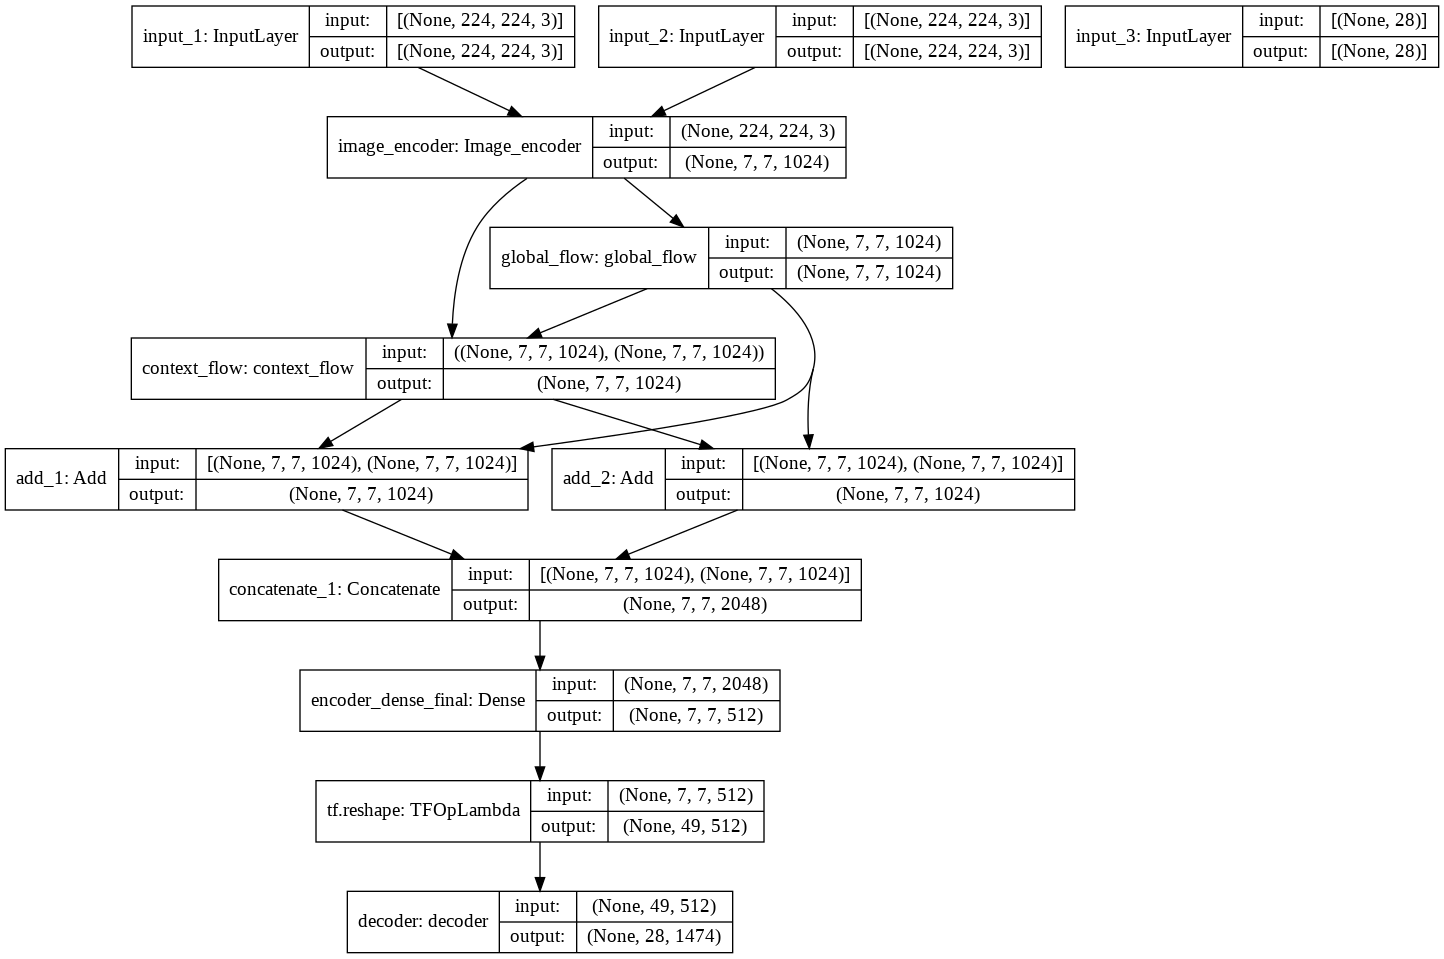

In [ ]:
def encoder_op(image1, image2, model = model1):
    """
    Given image1 and image2 filepath, outputs
    their backbone features which will be input
    to the decoder
    """
    image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED) / 255 
    image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED) / 255
    
    aug3 = iaa.Emboss(alpha = (1), strength = 1) #embosses image
    aug4 = iaa.Sharpen(alpha = (1.0), lightness = (1.5))
    
    image1 = aug4.augment_image(image1)
    image2 = aug4.augment_image(image2)
    
    image1 = aug3.augment_image(image1)
    image2 = aug3.augment_image(image2)
    
    image1 = tf.expand_dims(cv2.resize(image1, input_size, interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
    image2 = tf.expand_dims(cv2.resize(image2, input_size, interpolation = cv2.INTER_NEAREST),axis=0)

    image1 = model.get_layer('image_encoder')(image1) #output from chexnet
    image2 = model.get_layer('image_encoder')(image2)

    #global flow and context flow
    gf1 = model.get_layer('global_flow')(image1)
    cf1 = model.get_layer('context_flow')([image1, gf1])

    gf2 = model.get_layer('global_flow')(image1)
    cf2 = model.get_layer('context_flow')([image1, gf1])

    image1 = model.get_layer('add_1')([gf1, cf1])
    image2 = model.get_layer('add_2')([gf2, cf2])
    concat = model.get_layer('concatenate_1')([image1, image2])
    
    enc_op = model.get_layer('encoder_dense_final')(concat)
    enc_op = tf.reshape(enc_op,(-1, enc_op.shape[1] * enc_op.shape[2], enc_op.shape[3]))
    enc_op = model.get_layer('encoder_batch_norm')(enc_op) 
    enc_op = model.get_layer('encoder_dropout')(enc_op) #this is the output from encoder

    return enc_op

In [ ]:
def greedy_search_predict(image1, image2, model = model1):
    """
    Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
    """
    enc_op = encoder_op(image1, image2) #this is the output from encoder


    decoder_h, decoder_c = tf.zeros_like(enc_op[:, 0]), tf.zeros_like(enc_op[:, 0])
    a = []
    pred = []
    for i in range(max_pad):
        if i == 0: #if first word
            caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
        output, decoder_h, attention_weights = model.get_layer('decoder').onestepdecoder(caption, enc_op, decoder_h)

        #prediction
        max_prob = tf.argmax(output, axis=-1)  #tf.Tensor of shape = (1,1)
        caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
        if max_prob == np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
            break;
        else:
            a.append(tf.squeeze(max_prob).numpy())
            
    return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [ ]:
%%time
k = -1
image1, image2 = test.image_1.iloc[k],test.image_2.iloc[k]
print(greedy_search_predict(image1, image2, model1))

In [ ]:
%%time
_ = mean_bleu(test, greedy_search_predict)

In [ ]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1", "bleu2", "bleu3", "bleu4"], index = [index])
result

### **Beam Search**

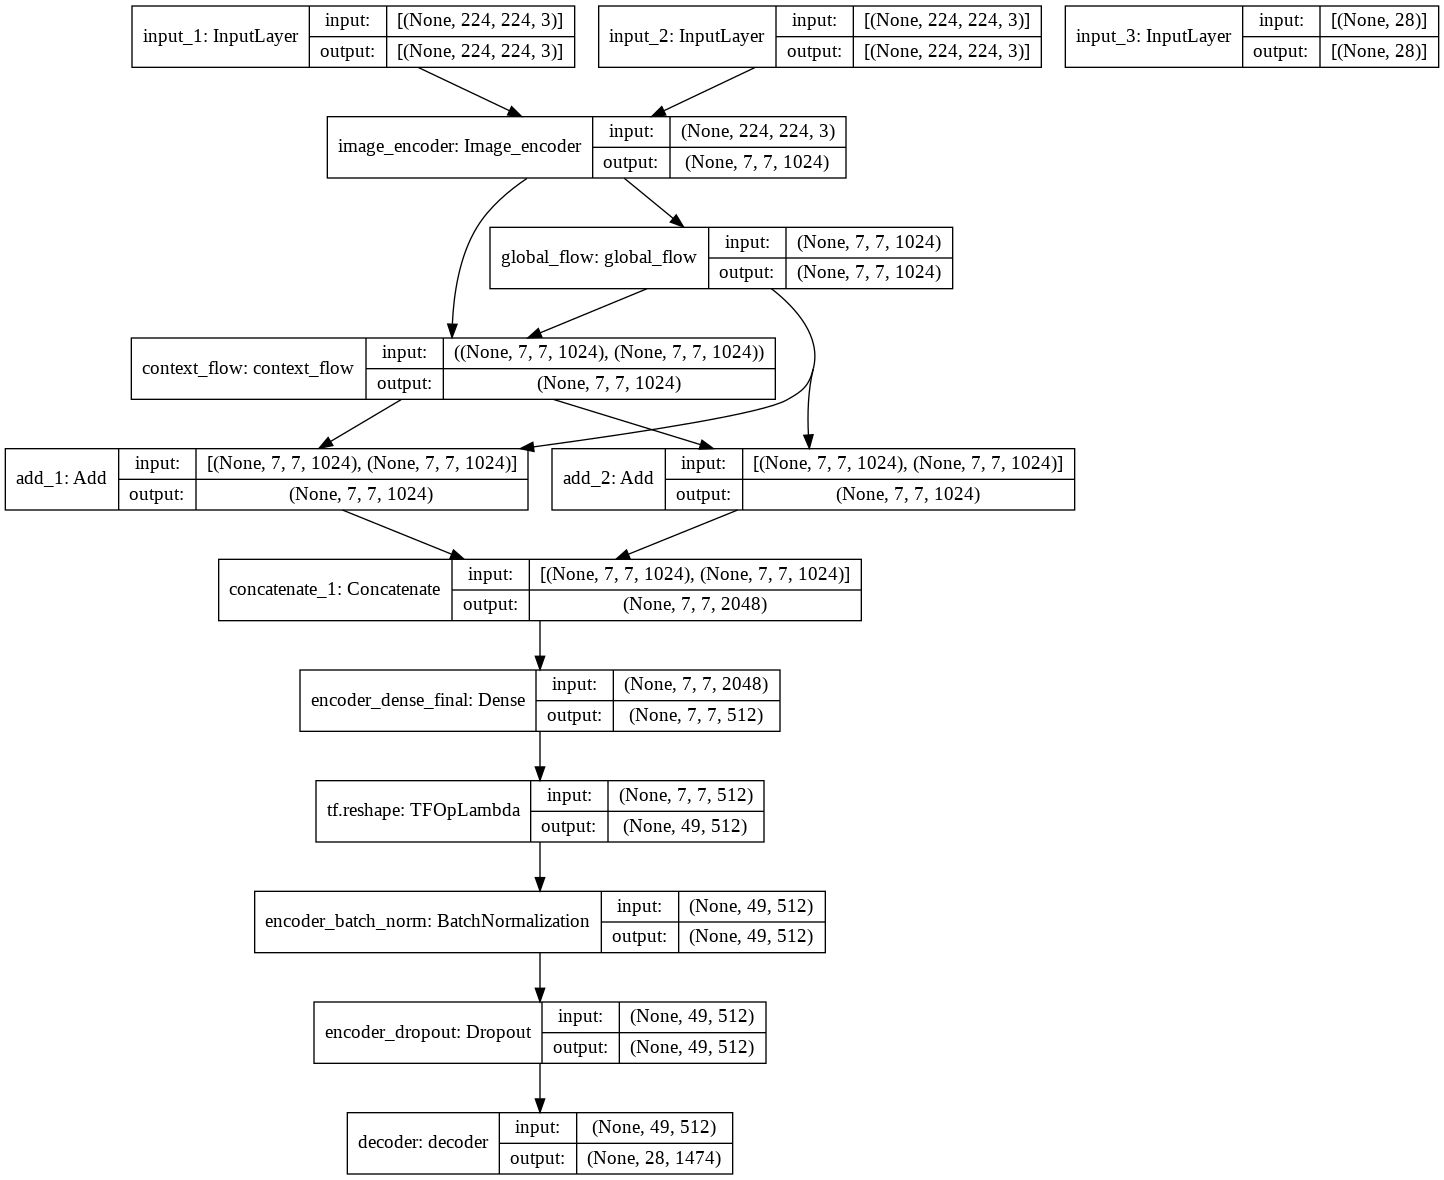

In [ ]:
def beam_search_predict(image1, image2, top_k = 3, max_pad = max_pad, model = model1):
    """
    Given image1, image2 get the top
    beam search predicted sentence
    """
    k = top_k
    cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
    enc_op = encoder_op(image1,image2)
    states = tf.zeros_like(enc_op[:,0]) #state_h only
    seq_score = [[cls_token,0,states]] #[[[3], 0]]
    finished_seq_score = []
    
    for i in range(max_pad): #traverse through all lengths
        all_candidates = [] #stores all the top k seq along with their scores
        new_seq_score = [] #stores the seq_score which does not have <end> in them
    
        for s in seq_score: #traverse for all top k sequences
            text_input = s[0][-1] #getting the last predicted output
            states = s[2]
            caption = np.array([[text_input]]) #ip must be in shape (batch_size,seq length,dim)
            output,states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_op,states) #here output has shape (1,vocab_size)
            top_words = tf.argsort(output[0],direction = 'DESCENDING')[:k] #get the top k words

            seq, score, _ = s
      
            for t in top_words.numpy():
                #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
                #here since its -(log), lower the score higher the prob
                candidates = [seq + [t], score-np.log(output[0][t].numpy()), states] #updating the score and seq
                all_candidates.append(candidates)
            
            seq_score = sorted(all_candidates, key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
            #checks for  <end> in each seq obtained
            count = 0
            end_token = tokenizer.word_index['<end>']
            
            for seq, score, state in seq_score:
                # print('seq,score',seq,score)
                if seq[-1] == end_token: #if last word of the seq is <end>
                    finished_seq_score.append([seq,score])
                    count += 1
                else:
                    new_seq_score.append([seq,score,state])
            k -= count #substracting the no. of finished sentences from beam length
            seq_score = new_seq_score

            if seq_score == []: #if null array
                break;
            else:
                continue;

    seq_score = finished_seq_score[-1]
    sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
    score = seq_score[1]
    
    return tokenizer.sequences_to_texts([sentence])[0]

In [ ]:
%%time
k = -1
image1, image2 = test.image_1.iloc[k], test.image_2.iloc[k]
print(beam_search_predict(image1, image2))

It took 6 min to get a prediction by beam search when k=3. Since its not feasible we will not be using beam search for this model.

# **Inference**

Now we will predict all datapoints with best approach chosen (here it is greedy search) and see the results manually and also compute bleu (1 gram) score.

In [ ]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search

for index,rows in test.iterrows():
    #greedy search
    predicted_text = greedy_search_predict(rows.image_1,rows.image_2, model1)
    test.loc[index, 'prediction_gs'] = predicted_text
    reference = [rows['impression'].split()]
    test.loc[index, 'bleu_1_gs'] = sentence_bleu(reference, predicted_text.split(), weights = (1,0,0,0))

In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

The model is predicting captions which are having similiar meanings. It is not doing worse than the baseline model as the baseline model where it was predicting majority of the test data with the same caption even though we did upsampling and downsampling of the data.

## Random predictions on test data

In [ ]:
def final_caption_pred(image1, image2, method = "beam", top_k = 3, model = model1):
    """
    Given image1 and image2 paths, the model, top_k and the method of prediction returns the predicted caption
    method: "greedy" for greedy search, "beam" for beam search
    """
    if method == 'greedy':
        pred_caption = greedy_search_predict(image1,image2,model)
    elif method == 'beam':
        pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
    else:
        print("Enter 'beam' for beam search or 'greedy' for greedy search")
  
    return pred_caption

In [ ]:
def inference(image1, image2, true_caption, model = model1, top_k = [3], image_size = (10,20)):
    """
    Given 2 images, the true caption, the model and the range of top_k
    prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
    """
    image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
    image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
    if type(top_k) == int:
        top_k = [top_k] #changing it to list if top_k given is of int type
    greedy_caption = final_caption_pred(image1,image2,method='greedy',model=model) #getting the greedy search prediction

    #printing the 2 images
    plt.figure(figsize = image_size)
    plt.subplot(121)
    plt.imshow(image1_array)
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(image2_array)
    plt.axis("off")
    plt.show()

    print("\nTrue caption: '%s'"%(true_caption))
    print("Predicted caption(greedy search): '%s'"%(greedy_caption))
    # beam search of top_k
    if top_k != None:
        for i in top_k:
            beam_caption = final_caption_pred(image1,image2,method='beam',model=model,top_k = i)
            print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


### Correct Captions (high bleu scores)

In [ ]:
i = test[test['bleu_1_gs'] > 0.5].sample(5).index
for j, k in enumerate(i):
    print(j+1,")")
    image1, image2 = test['image_1'][k], test['image_2'][k]
    true_caption = test['impression'][k]
    inference(image1, image2, true_caption)
    print("\n")

### Incorrect Caption (low bleu scores)


In [ ]:
i = test[test['bleu_1_gs']<=0.3].sample(5).index
for j,k in enumerate(i):
    print(j+1, ")")
    image1, image2 = test['image_1'][k], test['image_2'][k]
    true_caption = test['impression'][k]
    inference(image1, image2, true_caption)
    print("\n")

We can see from both of the correct and incorrect captions that the model is doing pretty good since it is predicting captions that are near to the true captions except for some. 

We can see that most of the high bleu score captions were correct and only 1 were low bleu score had entirely different meaning, other predicted captions conveyed similiar meaning. Even then this is performing far better than the baseline model since it was only predicting "no cardiopulmonary abnormaity" 100% of test data. This is not better than attention model because there it had more variability. Here only fewer than 10 unique predictions were there.

# For comparisons

For comparing the results with other results, we willl predict captions on 6 test data.

In [ ]:
k = 3
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

In [ ]:
k = 536
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

In [ ]:
k = 541
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

In [ ]:
k = 562
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

In [ ]:
k = 451
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

In [ ]:
k = 456
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption)

Here the model is predicting only those images which have no disease correctly but for others it is not.

# Conclusion

In [ ]:
result

The model performed better than that of baseline model by producing more vairability in its output. This model performed better  when the images were of no diseases. But it predicted worse when there was actual disease in the images. We need to have more data specifically more images and captions which have actual diseases since we have large amounts of images and captions of "type no diseases".  